## 1. Bellman Optimality Equations
$$
\begin{align}
\epsilon_{k+1}&= \quad || v_{k+1}(s)-v_{*}(s)||_{\infty}\quad\\
&= \quad \max\limits_s(\vert\max\limits_a(\sum\limits_{s',r}P(s',r|s,a)[r+\gamma\cdot v_{k}(s')] - \max\limits_a'(\sum\limits_{s',r}P(s',r|s,a')[r+\gamma\cdot v_{*}(s')]\vert)\\
&= \quad \max\limits_s(\vert\max\limits_{a}(\sum\limits_{s',r}P(s',r|s,a) \cdot \gamma \cdot[v_k(s')-v_*(s')])\vert)\\
&\leq \quad \gamma \cdot\vert \max_{s'}[v_k(s')-v_*(s')] \vert\\
&= \quad\gamma\cdot||v_k(s)-v_*(s)||_{\infty}\\
&= \quad \gamma \cdot \epsilon_{k} \quad \gamma \in (0,1), k=1...T\\
&s.t. \quad \epsilon_{k+1} \leq \gamma^k \epsilon_1
\end{align}
$$

Therefore Bellman optimality equation converges.

## 2. Policy Iteration
## 2.1 Policy Improvement Guarantees
Let's say we have an old policy $\pi$ and a changed policy $\pi'$. 

In policy improvement phase, $\pi'(s)=\max\limits_aq_\pi(s,a)$, for $s \in S$.

So, $v_\pi(s) \leq q_\pi(s,\pi'(s))$, that is to say, the old policy can be improved by choosing a new immediate action denoted as $\pi'(s)$ and then follows itself again.

Therefore it follows that:

$$
\begin{align}
v_\pi(s) \quad &\leq \quad q_\pi(s,\pi'(s))\\
&= \quad \mathop{\mathbb{E}_{\pi'}}[R_{t+1}+\gamma\cdot v_\pi(S_{t+1})\mid S_t=s]\\
&\leq \quad \mathop{\mathbb{E}_{\pi'}}[R_{t+1}+ \gamma\cdot q_\pi(S_{t+1},\pi'(S_{t+1}))\mid S_t=s]\\
&= \quad \mathop{\mathbb{E}_{\pi'}}[R_{t+1}+\gamma\cdot\mathop{\mathbb{E}_{\pi'}}[R_{t+2}+\gamma\cdot v_\pi(S_{t+2})\mid S_t=s]\\
&=\quad \mathop{\mathbb{E}_{\pi'}}[R_{t+1}+\gamma\cdot R_{t+2}+\gamma^2\cdot v_\pi(S_{t+2})\mid S_t=s]\\
&...\\
&\leq \quad \mathop{\mathbb{E}_{\pi'}}[R_{t+1}+\gamma\cdot R_{t+2} + \gamma ^2\cdot R_{t+3}...\mid S_t=s]\\
&= \quad v_{\pi'}(s)
\end{align}
$$

which holds true for all $s \in S$, and note that $S_{t+1}$, $S_{t+2}$...are random variables. This demonstrates that the policy is always improving.

## 2.2 Finite iteration

A finite MDP has a finite number of states thus a finite number of policies. Policy iteration can go thourgh each one of them and it is inevitable that the algorithm finds one of the optimal policies in seom number of iterations. And once it finds that policy, the value function is optimal hence stops improving, making the policy stable therefore the algorithm terminates.

## 2.3 Optimal Policy Guarantees

If $v_{\pi'}(s)=v_\pi(s)$ for all $s \in S$, then: $\pi'(s)=\max\limits_aq_\pi(s,a) = \max\limits_a\sum\limits_{s',r}p(s',r\mid s,a)[r+\gamma\cdot v_{\pi}(s')]$, for all $s \in S$, which is exactly the Bellman optimality equation, therefore $v_{\pi'}$ must be the optimal policy $v_*$; so does $v_\pi$.

## 3 Policy Iteration, Value Iteration and Improved Iteration algorithms
### 3.1 Simple MDP

In [0]:
import numpy as np

class MDP:
    pass

class SimpleMDP(MDP):

    def __init__(self):
        self.states = ['s0', 's1']
        self.actions = ['a0', 'a1', 'a2']
        self.valid_actions = [[0,1],[2]]
        # |S| * |A| -> |S|
        self.transition = np.array(([
            [
                [0.5, 0.5],  # a0
                [0, 1],  # a1
                [0, 0]  # a2
            ],  # state 0
            [
                [0, 0],
                [0, 0],
                [0, 1]
            ]  # state 1
        ]))
        # |S| * |A| -> R
        self.reward = np.array([
            [5, 10, 0],
            [0, 0, -1]
        ])


class PolicyLearner:

    def __init__(self, mdp, discount=0.95, theta=1e-10):
        self.mdp = mdp
        self.discount = discount
        self.theta = theta
        self.nb_states = len(mdp.states)
        self.nb_actions = len(mdp.actions)

    def PolicyEvaluation(self, partial = False, partial_iteration_limit=100):
        mask = [[False, False, True], [True, True, False]]
        r_vec = np.sum(np.multiply(np.ma.masked_array(self.policy, mask),
                                   np.ma.masked_array(self.mdp.reward, mask)), axis=1).data
        # print(r_vec.shape)

        p_mat = []
        for i in range(self.nb_states):
            trans = np.matmul(np.ma.masked_array(self.policy[i], mask[i]),
                              np.ma.masked_array(self.mdp.transition[i], np.stack((mask[i], mask[i])).T)).data
            p_mat.append(trans)
        p_mat = np.array(p_mat)

        count = 0
        while (True):
            count += 1

            v = self.value_fun.copy()
            self.value_fun = r_vec + self.discount * np.matmul(p_mat, self.value_fun)
            delta = np.max(np.abs(v - self.value_fun))
            # print(self.value_fun)
            if delta < self.theta:
                print('Sweep count:',count)
                print('value function:', self.value_fun)
                break

            if partial is True and count >= partial_iteration_limit:
                print('Sweep count:', count)
                print('value function:', self.value_fun)
                break


    def PolicyImprovement(self):
        stable = True
        for i in range(self.nb_states):
            # find the argmax action
            q = np.full((self.nb_actions), fill_value=-np.inf)
            for j in self.mdp.valid_actions[i]:
                q[j] = self.mdp.reward[i, j] + self.discount * \
                        np.sum(np.multiply(self.mdp.transition[i, j], self.value_fun))
            # print(q)
            argmax_q = np.argmax(q)
            # print(argmax_q)
            prev_action = np.argmax(self.policy[i])
            # print(q)
            # print('state: {}, prev_q:{}, max_q:{}')
            if prev_action != argmax_q:
                print('policy update: (state {} -> action {})'.format(i, argmax_q))
                stable = False
                self.policy[i][prev_action] = 0
                self.policy[i][argmax_q] = 1
        return stable

    def PolicyIteration(self):
        # initialization
        self.policy = np.zeros((self.nb_states, self.nb_actions))
        #     for i in range(self.nb_states):
        #       self.policy[i,int(np.random.rand()*3)] = 1
        # only legit actions
        self.policy[0, int(np.random.rand() * 2)] = 1
        self.policy[1, 2] = 1
        self.value_fun = np.zeros((self.nb_states,))

        print('Initial policy:\n', self.policy)

        while (True):
            self.PolicyEvaluation()
            if self.PolicyImprovement():
                print('Itertion finished')
                print('policy:\n', self.policy)
                break

    def ValueIteration(self):
        # initialization
        self.value_fun = np.zeros((self.nb_states,))
        count = 0
        while(True):
            count += 1
            v = self.value_fun.copy()
            q = np.full((self.nb_states, self.nb_actions), fill_value=-np.inf)
            for i in range(self.nb_states):
                for j in self.mdp.valid_actions[i]:
                    q[i][j] = self.mdp.reward[i, j] + self.discount * \
                           np.sum(np.multiply(self.mdp.transition[i, j], self.value_fun))
                self.value_fun[i] = np.max(q[i])

            # print(v)
            # print(self.value_fun)
            delta = np.max(np.abs(v - self.value_fun))

            if delta < self.theta:
                print('Sweep count:', count)
                print('value function:', self.value_fun)
                self.q = q
                break
        tmp = np.argmax(q, axis = 1)
        self.policy = np.zeros((self.nb_states, self.nb_actions))
        for i in range(self.nb_states):
            self.policy[i][tmp[i]] = 1
        print('Policy:\n', self.policy)

    def ImprovedPolicyIteration(self, partial_iteration_limit):
        self.policy = np.zeros((self.nb_states, self.nb_actions))
        self.policy[0, int(np.random.rand() * 2)] = 1
        self.policy[1, 2] = 1
        self.value_fun = np.zeros((self.nb_states,))
        print('Initial policy:\n', self.policy)
        while (True):
            self.PolicyEvaluation(partial=True, partial_iteration_limit=partial_iteration_limit)
            if self.PolicyImprovement():
                print('Itertion finished')
                print('policy:\n', self.policy)
                break

Test run.

In [2]:
learner = PolicyLearner(SimpleMDP())
print('Policy Iteration for exmaple MDP')
learner.PolicyIteration()
print('\n')
print('Value Iteration for example MDP')
learner.ValueIteration()
print('\n')
print('Partial Policy Iteration for example MDP')
learner.ImprovedPolicyIteration(partial_iteration_limit=50)

Policy Iteration for exmaple MDP
Initial policy:
 [[1. 0. 0.]
 [0. 0. 1.]]
Sweep count: 450
value function: [ -8.57142857 -20.        ]
Itertion finished
policy:
 [[1. 0. 0.]
 [0. 0. 1.]]


Value Iteration for example MDP
Sweep count: 450
value function: [ -8.57142857 -20.        ]
Policy:
 [[1. 0. 0.]
 [0. 0. 1.]]


Partial Policy Iteration for example MDP
Initial policy:
 [[0. 1. 0.]
 [0. 0. 1.]]
Sweep count: 50
value function: [ -7.46110049 -18.46110049]
policy update: (state 0 -> action 0)
Sweep count: 50
value function: [ -8.45301799 -19.88158942]
Itertion finished
policy:
 [[1. 0. 0.]
 [0. 0. 1.]]


### 3.2 Gridworld MDP
A 4 $\times$ 4 Grid MDP, equivalent to the one on the slide.

In [0]:
class GridMDP(MDP):
    '''
        A 4 by 4 grid.
        Equivalent to the Small Gridworld in course slides.
        '''
    def __init__(self):
        # only non terminal states
        self.states = np.arange(16)
        self.nonterminal_states = np.arange(1,15)
        self.actions = ['top', 'right', 'down', 'left']

        self.transition = []
        self.reward = []
        for s in self.states:
            mat = np.zeros((len(self.actions), len(self.states)))
            if s-4>=0:
                mat[0][s - 4] = 1
            else:
                mat[0][s] = 1
            if (s+1)%4!=0:
                mat[1][s + 1] = 1
            else:
                mat[1][s] = 1
            if s+4<=15:
                mat[2][s + 4] = 1
            else:
                mat[2][s] = 1
            if s%4!=0:
                mat[3][s - 1] = 1
            else:
                mat[3][s] = 1
            self.transition.append(mat)
            self.reward.append(np.full(len(self.actions), fill_value=-1))
        self.transition = np.array(self.transition)
        self.reward = np.array(self.reward)
        # self.reward[0] = np.zeros(4)
        # self.reward[15] = np.zeros(4)


class GridPolicyLearner:

    def __init__(self, mdp, discount=0.95, theta=1e-10):
        self.mdp = mdp
        self.discount = discount
        self.theta = theta
        self.nb_states = len(mdp.states)
        self.nb_actions = len(mdp.actions)

    def print_value_fun(self):
        for i in (0, 4, 8, 12):
            print("\t".join(['{:.2f}'.format(c) for c in self.value_fun[i:i + 4]]))

    def print_actions(self):
        vis = [['terminal', 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 'terminal']]
        for i in range(4):
            for j in range(4):
                if (i, j) == (0, 0) or (i, j) == (3, 3):
                    continue
                vis[i][j] = self.mdp.actions[np.argmax(self.policy[4 * i + j])]
        print('policy:')
        # print(self.policy)
        for row in vis:
            print("{:<12} {:<12} {:<12} {:<12}".format(row[0], row[1], row[2], row[3]))

    def PolicyEvaluation(self, partial = False, partial_iteration_limit=100):
        r_vec = np.sum(np.multiply(self.policy, self.mdp.reward), axis=1)
        # print(r_vec.shape)

        p_mat = []
        for i in range(self.nb_states):
            trans = np.matmul(self.policy[i], self.mdp.transition[i])
            p_mat.append(trans)
        p_mat = np.array(p_mat)

        count = 0
        while (True):
            count += 1

            v = self.value_fun.copy()
            self.value_fun = r_vec + self.discount * np.matmul(p_mat, self.value_fun)
            delta = np.max(np.abs(v - self.value_fun))
            # print(self.value_fun)
            if delta < self.theta:
                print('Sweep count:',count)
                print('value function:')
                self.print_value_fun()
                break

            if partial is True and count >= partial_iteration_limit:
                print('Sweep count:', count)
                print('value function:')
                self.print_value_fun()
                break
        return count


    def PolicyImprovement(self):
        stable = True
        for i in range(self.nb_states):
            # don't need to update actions for terminal states — they have no actions.
            if i == 0 or i == 15:
                continue
            # find the argmax action
            q = np.full((self.nb_actions), fill_value=-np.inf)
            for j in range(self.nb_actions):
                q[j] = self.mdp.reward[i, j] + self.discount * \
                        np.sum(np.multiply(self.mdp.transition[i, j], self.value_fun))

            argmax_q = np.argmax(q)
            prev_action = np.argmax(self.policy[i])

            if prev_action != argmax_q:
                print('policy update: (state {} -> action {})'.format(i, argmax_q))
                stable = False
                self.policy[i] = np.zeros(self.nb_actions)
                self.policy[i][argmax_q] = 1
            else:
                self.policy[i] = np.zeros(self.nb_actions)
                self.policy[i][prev_action] = 1
        return stable

    def PolicyIteration(self):
        # initialization
        total = 0
        self.policy = np.full((self.nb_states, self.nb_actions), fill_value=0.25)
        # mask out actions for state 0 and state 1
        self.policy[0,:] = np.zeros(self.nb_actions)
        self.policy[15, :] = np.zeros(self.nb_actions)
        self.value_fun = np.zeros((self.nb_states,))

#        print('Initial policy:\n', self.policy)

        while (True):
            total += self.PolicyEvaluation()
            if self.PolicyImprovement():
                print('Itertion finished')
                self.print_actions()
                break
        return total

    def ValueIteration(self):
        # initialization
        self.value_fun = np.zeros((self.nb_states,))
        count = 0
        while(True):
            count += 1
            v = self.value_fun.copy()
            q = np.full((self.nb_states, self.nb_actions), fill_value=-np.inf)
            for i in range(self.nb_states):
                if i==0 or i==15:
                    continue
                for j in range(self.nb_actions):
                    q[i][j] = self.mdp.reward[i, j] + self.discount * \
                           np.sum(np.multiply(self.mdp.transition[i, j], self.value_fun))
                self.value_fun[i] = np.max(q[i])

            delta = np.max(np.abs(v - self.value_fun))

            if delta < self.theta:
                print('Sweep count:', count)
                print('value function:')
                self.print_value_fun()
                self.q = q
                break
        tmp = np.argmax(q, axis = 1)
        self.policy = np.zeros((self.nb_states, self.nb_actions))
        for i in range(self.nb_states):
            self.policy[i][tmp[i]] = 1
        self.print_actions()
        return count

    def ImprovedPolicyIteration(self, partial_iteration_limit):
        # initialization
        total = 0
        self.policy = np.full((self.nb_states, self.nb_actions), fill_value=0.25)
        # mask out actions for state 0 and state 1
        self.policy[0, :] = np.zeros(self.nb_actions)
        self.policy[15, :] = np.zeros(self.nb_actions)
        self.value_fun = np.zeros((self.nb_states,))

        while (True):
            total += self.PolicyEvaluation(partial=True, partial_iteration_limit=partial_iteration_limit)
            if self.PolicyImprovement():
                print('Itertion finished')
                self.print_actions()
                break
        return total

In [4]:
learner = GridPolicyLearner(GridMDP())
print('Policy Iteration for Gridworld')
learner.PolicyIteration()
print('\n')
print('Value Iteration for Gridworld')
learner.ValueIteration()
print('\n')
print('Modified Value Iteration for Gridworld')
learner.ImprovedPolicyIteration(partial_iteration_limit=50)
print('\n')

Policy Iteration for Gridworld
Sweep count: 221
value function:
0.00	-7.59	-10.53	-11.43
-7.59	-9.63	-10.58	-10.53
-10.53	-10.58	-9.63	-7.59
-11.43	-10.53	-7.59	0.00
policy update: (state 1 -> action 3)
policy update: (state 2 -> action 3)
policy update: (state 3 -> action 2)
policy update: (state 6 -> action 2)
policy update: (state 7 -> action 2)
policy update: (state 10 -> action 1)
policy update: (state 11 -> action 2)
policy update: (state 13 -> action 1)
policy update: (state 14 -> action 1)
Sweep count: 4
value function:
0.00	-1.00	-1.95	-2.85
-1.00	-1.95	-2.85	-1.95
-1.95	-2.85	-1.95	-1.00
-2.85	-1.95	-1.00	0.00
policy update: (state 6 -> action 0)
Sweep count: 1
value function:
0.00	-1.00	-1.95	-2.85
-1.00	-1.95	-2.85	-1.95
-1.95	-2.85	-1.95	-1.00
-2.85	-1.95	-1.00	0.00
Itertion finished
policy:
terminal     left         left         down        
top          top          top          down        
top          top          right        down        
top          right        ri

In [0]:
import sys, os

# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__
    
    
def _test_gridworld(discount, suppress_print=False):
    '''

    :param discount:
    :return: convergence sweep counts for each of the 3 algorithms
    '''
    if suppress_print:
        blockPrint()
    else:
        enablePrint()
    print(discount)
    conv_count = []
    learner = GridPolicyLearner(GridMDP(),discount=discount)
    print('Policy Iteration for Gridworld')
    conv_count.append(learner.PolicyIteration())
    print('\n')
    print('Value Iteration for Gridworld')
    conv_count.append(learner.ValueIteration())
    print('\n')
    print('Modified Value Iteration for Gridworld')
    conv_count.append(learner.ImprovedPolicyIteration(partial_iteration_limit=50))
    print('\n')
    return np.array(conv_count)

Demonstrating empirical results for convergence with different discount factor.

['Policy Iteration', 'Value Iteration', 'Improved Policy Iteration']


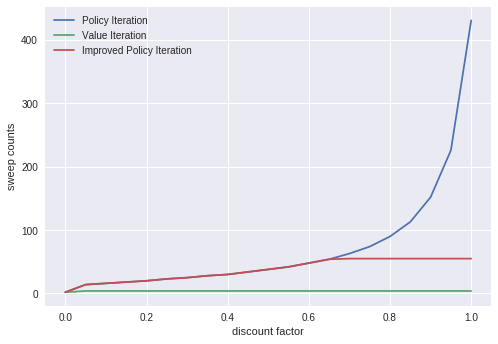

In [6]:
import matplotlib.pyplot as plt
legend = ['Policy Iteration', 'Value Iteration', 'Improved Policy Iteration']
print(legend)
count = []
for discount_factor in np.arange(0,1.05,0.05):
    count.append(_test_gridworld(discount_factor, suppress_print=True))
count = np.array(count)
# print(count)
plt.figure()
plt.ylabel('sweep counts')
plt.xlabel('discount factor')
for i in range(3):
    plt.plot(np.arange(0,1.05,0.05),count[:,i], label=legend[i])
plt.legend()
plt.show()

From the graph we can see that the convergence rate of value iteration is constant (4 sweeps) notwithstanding the discount factor; in comparison, policy iteration algorithm is exponentially proportional to the discount factor. Improved value iteration is moderate with respect to discount factor, whose maximum iteration per round is set to 50. The sweep counts of this algorithm remains constant after the discount factor go over a certain threshold.